In [24]:
import requests
import os
import zipfile
import pandas as pd
import numpy as np
from scipy.stats import kruskal
import statsmodels.stats.multitest as smm
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

# Skin (Supplementary Figure 3j)

In [25]:
#let's download and import the feature table directly from the FBMN job in GNPS2
task_id = '5f30dc8527bb456190daf2e772bf399d'
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = '/.../directory_path/'

#import the metadata
metadata = pd.read_csv('/.../metadata_body_decomposition.txt', sep='\t')
column_interest = 'ATTRIBUTE_ADDGroup' #this is the column in the metadata table we will work with
sample_type = 'Skin' 

with open(directory_path + task_id + '.csv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
ftable = pd.read_csv(os.path.join(directory_path + task_id + '.csv'), sep=',')
#just keep the column relative to the samples and feature ids.
ftable = ftable[[col for col in ftable.columns if col.endswith('Peak area') or col == 'row ID']]

#import library matches to N-acyl lipids massQL library
library_matches = pd.read_csv('https://gnps2.org/resultfile?task=' + task_id + '&file=nf_output/library/merged_results_with_gnps.tsv', sep='\t')
    
#create another column with simplified annotations:
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name'].str.split('(').str[0]
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name_simplified'].str.replace('Candidate ', '', regex=True)

#create a new column with the scans with a prefix
prefix = 'MS_'
library_matches['MS_#Scan#'] = library_matches['#Scan#'].apply(lambda x: f'{prefix}{x}')


File saved at /Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/Examples_lipids/


In [26]:
#filter down the feature table to only have the features that matched the massQL library
list_matches = library_matches['#Scan#'].to_list()
ftable_filtered = ftable[ftable['row ID'].isin(list_matches)]

# formatting table for box plots
ftable_filtered = ftable_filtered.T
ftable_filtered = ftable_filtered.reset_index()
ftable_filtered.columns = ftable_filtered.iloc[0]
ftable_filtered = ftable_filtered[1:]
ftable_filtered = ftable_filtered.add_prefix(prefix)
ftable_filtered = ftable_filtered.rename(columns={'MS_row ID': 'filename'})
ftable_filtered.head()

#remove .mzML/.mzXML from metadata file and ftable
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzML', '') if x.endswith('.mzML') else x)
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzXML', '') if x.endswith('.mzXML') else x)

ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzML Peak area', '') if x.endswith('.mzML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzXML Peak area', '') if x.endswith('.mzXML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('_rerun', '') if x.endswith('_rerun') else x)

#merge and reorganize
ftable_filtered_merged = pd.merge(ftable_filtered, metadata[['filename', 'ATTRIBUTE_SampleType',
                                                             column_interest]], on='filename', how='left')
#keep skin
ftable_filtered_merged = ftable_filtered_merged[ftable_filtered_merged['ATTRIBUTE_SampleType'] == sample_type]

ftable_filtered_merged.columns = [col.replace('.0', '') if col.endswith('.0') else col for col in ftable_filtered_merged.columns]
last_column = ftable_filtered_merged.iloc[:, -1]
ftable_filtered_merged = pd.concat([last_column, ftable_filtered_merged.iloc[:, :-1]], axis=1)

#delete last column
ftable_filtered_merged = ftable_filtered_merged.drop(ftable_filtered_merged.columns[-1], axis=1)

#put in the desired order
order = ['Day0', 'early', 'active', 'advanced']
ftable_filtered_merged[column_interest] = pd.Categorical(ftable_filtered_merged[column_interest], 
                                                            categories=order, ordered=True)
ftable_filtered_merged = ftable_filtered_merged.sort_values(column_interest)
ftable_filtered_merged = ftable_filtered_merged[ftable_filtered_merged[column_interest].isin(order)]


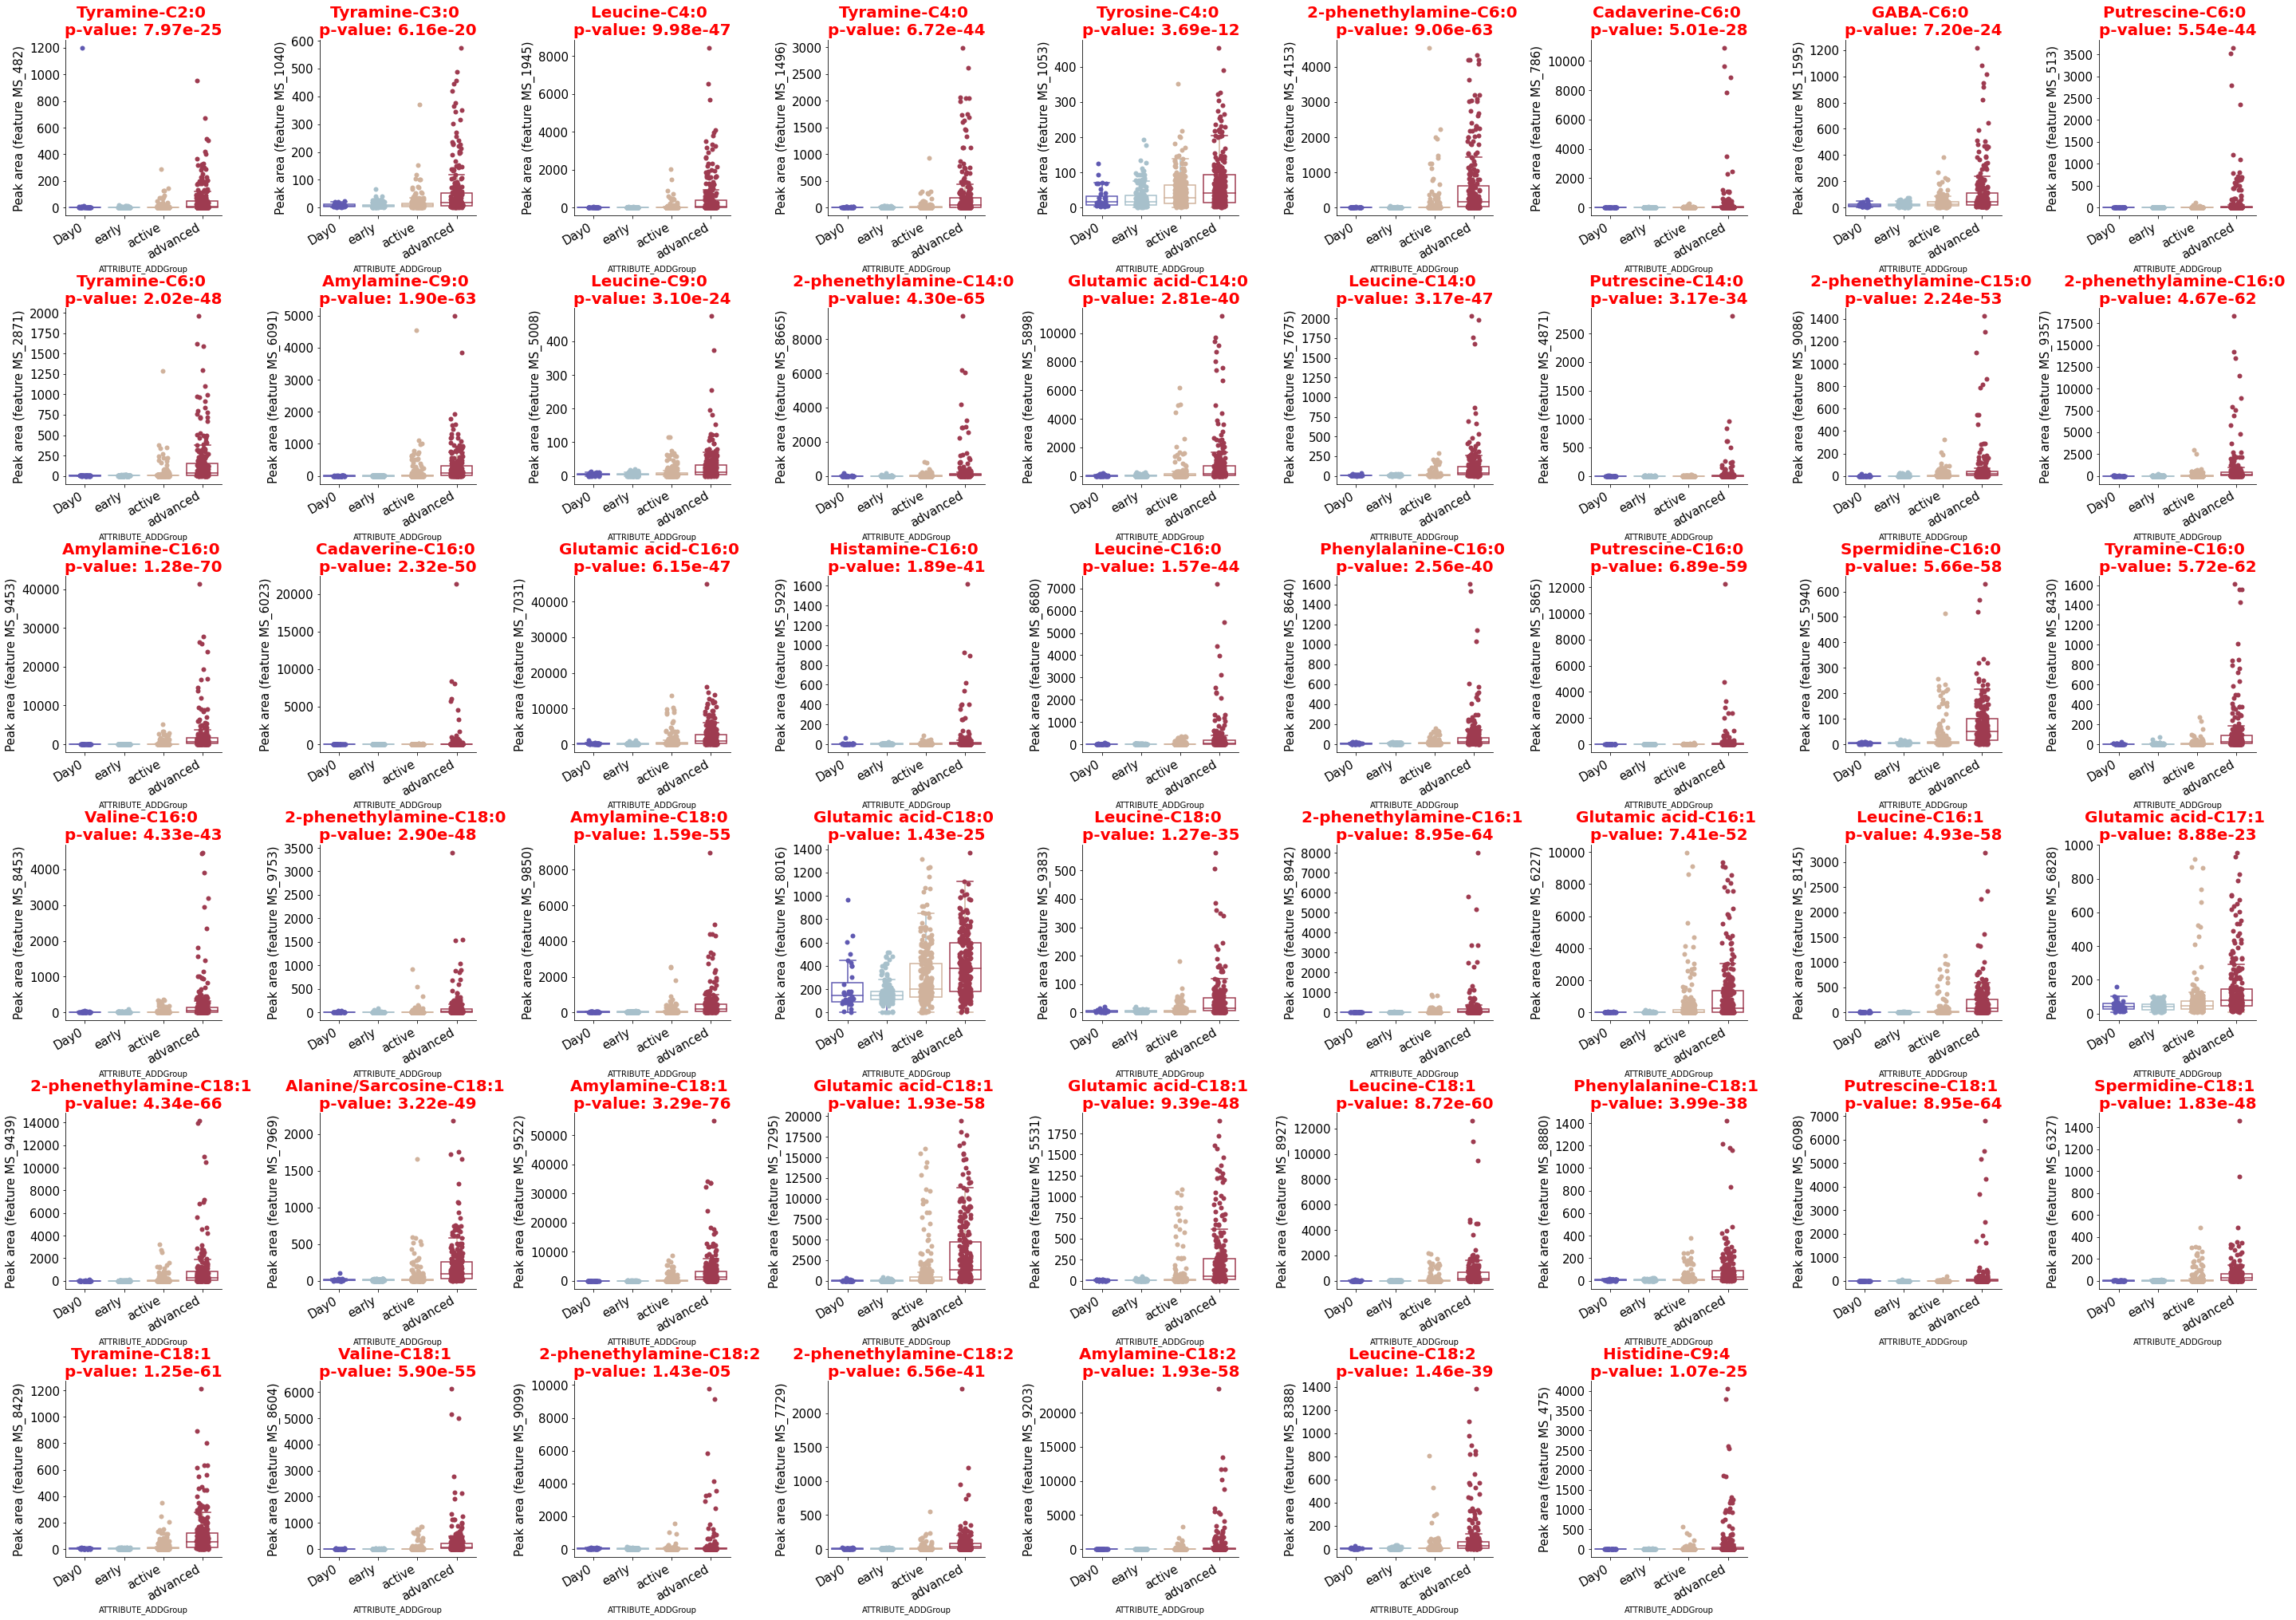

In [27]:
#reorganize the column order
metadata = pd.read_csv('/.../deltas_annotation_reordered.txt', sep='\t')
metadata['order'] = metadata['order'].astype(str).str.zfill(3)
ms_features = pd.DataFrame(ftable_filtered_merged.columns[2:], columns=['MS_#Scan#'])
ms_features = pd.merge(ms_features, library_matches[['MS_#Scan#', 'Compound_Name_simplified']], 
                       on='MS_#Scan#', how='left')
ms_features['annotation'] = ms_features['Compound_Name_simplified'].str.split('-').str[-1]
ms_features['annotation'] = ms_features['annotation'].str.replace(' ','')
ms_features = pd.merge(ms_features, metadata[['annotation','order']], on='annotation', how='left')
ms_features['order'] = ms_features['order'].astype(str) + '_'+ ms_features['Compound_Name_simplified'].str.split('-').str[0]
ms_features_reordered = ms_features.sort_values(by='order', ascending=True)

ordered_feature_names = ms_features_reordered['MS_#Scan#'].tolist()

# Placeholder dictionary to hold p-values
p_values = {}

# Assuming 'column_interest' categorizes the data into four groups
group_labels = ftable_filtered_merged[column_interest].unique()
if len(group_labels) < 2:
    raise ValueError("column_interest must divide the data into at least two groups for the Kruskal-Wallis test.")

for feature_name in ordered_feature_names:
    # Data for all groups
    group_data = [ftable_filtered_merged[ftable_filtered_merged[column_interest] == label][feature_name] for label in group_labels]
    
    # Perform the Kruskal-Wallis test
    k_stat, p_value = kruskal(*group_data)
    p_values[feature_name] = p_value

# Exclude any NaN p-values before FDR correction
pvals = [p for p in p_values.values() if not np.isnan(p)]
features = [f for f, p in p_values.items() if not np.isnan(p)]

# Apply FDR correction
rej, pvals_corrected, _, _ = smm.multipletests(pvals, alpha=0.05, method='fdr_bh')

# Update the p_values dictionary with corrected p-values
corrected_p_values = dict(zip(features, pvals_corrected))
p_values.update(corrected_p_values)

#plot
plt.figure(figsize=(40, 60))  # Adjust the figure size as needed

unique_values = ftable_filtered_merged[column_interest].unique().tolist()
ftable_filtered_merged[column_interest] = pd.Categorical(
    ftable_filtered_merged[column_interest], categories=unique_values, ordered=True)

# Function to generate a color palette
def generate_palette(n):
    return sns.color_palette("twilight_shifted", n)

# Assigning palette
my_pal = generate_palette(len(unique_values))
color_dict = {str(val): color for val, color in zip(unique_values, my_pal)}
color_dict_white = {key: 'white' for key in color_dict.keys()}
plt.yticks(fontsize=15)

for i, feature_name in enumerate(ordered_feature_names, 1):
    title_name = library_matches.loc[library_matches['MS_#Scan#'] == feature_name, 'Compound_Name_simplified'].iloc[0]
    plt.subplot(12, 9, i)
  
    fig = sns.boxplot(x=column_interest, y=feature_name, data=ftable_filtered_merged, notch=False, 
                      palette=color_dict_white, showfliers=False)    
    
    # Set box properties including edge color to match your palette
    for j, patch in enumerate(fig.artists):
        col = color_dict[ftable_filtered_merged[column_interest].unique()[j]]
        patch.set_edgecolor(col)

        num_lines = len(fig.lines)
        start_line_index = 6 * j
        end_line_index = start_line_index + 6
        for k in range(start_line_index, min(end_line_index, num_lines)):
            line = fig.lines[k]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Add colored dots for each category
    for diet in ftable_filtered_merged[column_interest].unique():
        sns.stripplot(
            x=column_interest, 
            y=feature_name, 
            data=ftable_filtered_merged[ftable_filtered_merged[column_interest] == diet], 
            color=color_dict[diet], 
            jitter=0.15, 
            size=6,
            ax=fig
        )
    # Determine title color based on p-value
    if p_values[feature_name] <= 0.05:
        title_color = 'red'
        title_weight = 'bold'
    else:
        title_color = 'black'
        title_weight = 'normal'
        
    fig.set_ylabel(f'Peak area (feature {feature_name})', fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(rotation=30, ha='right', fontsize=15)
    
    formatted_p_value = f"{p_values[feature_name]:.2e}"
    plt.title(f'{title_name}\np-value: {formatted_p_value}', fontsize=20, color=title_color, fontweight=title_weight)
    
plt.tight_layout()
plt.subplots_adjust(top=0.91)
sns.despine()

plt.savefig("/.../Supplementary_Figure_3j.pdf")
plt.show()


# Soil (Supplementary Figure 3k)

In [28]:
#let's download and import the feature table directly from the FBMN job in GNPS2
task_id = '5f30dc8527bb456190daf2e772bf399d'
response = requests.get(f'https://gnps2.org/result?task={task_id}&viewname=quantificationdownload&resultdisplay_type=task')
directory_path = '/.../directory_path/'

#import the metadata
metadata = pd.read_csv('/.../metadata_body_decomposition.txt', sep='\t')
column_interest = 'ATTRIBUTE_ADDGroup' #this is the column in the metadata table we will work with
sample_type = 'Soil' 

with open(directory_path + task_id + '.csv', 'wb') as f:
    f.write(response.content)
    print(f"File saved at {directory_path}")
    
ftable = pd.read_csv(os.path.join(directory_path + task_id + '.csv'), sep=',')
#just keep the column relative to the samples and feature ids.
ftable = ftable[[col for col in ftable.columns if col.endswith('Peak area') or col == 'row ID']]

#import library matches to N-acyl lipids massQL library
library_matches = pd.read_csv('https://gnps2.org/resultfile?task=' + task_id + '&file=nf_output/library/merged_results_with_gnps.tsv', sep='\t')
    
#create another column with simplified annotations:
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name'].str.split('(').str[0]
library_matches['Compound_Name_simplified'] = library_matches['Compound_Name_simplified'].str.replace('Candidate ', '', regex=True)

#create a new column with the scans with a prefix
prefix = 'MS_'
library_matches['MS_#Scan#'] = library_matches['#Scan#'].apply(lambda x: f'{prefix}{x}')


File saved at /Users/helenarusso/Documents/Pesquisa/UCSD Post-doc/Acyl lipids/Examples_lipids/


In [29]:
#filter down the feature table to only have the features that matched the massQL library
list_matches = library_matches['#Scan#'].to_list()
ftable_filtered = ftable[ftable['row ID'].isin(list_matches)]

# formatting table for box plots
ftable_filtered = ftable_filtered.T
ftable_filtered = ftable_filtered.reset_index()
ftable_filtered.columns = ftable_filtered.iloc[0]
ftable_filtered = ftable_filtered[1:]
ftable_filtered = ftable_filtered.add_prefix(prefix)
ftable_filtered = ftable_filtered.rename(columns={'MS_row ID': 'filename'})
ftable_filtered.head()

#remove .mzML/.mzXML from metadata file and ftable
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzML', '') if x.endswith('.mzML') else x)
metadata['filename'] = metadata['filename'].apply(lambda x: x.replace('.mzXML', '') if x.endswith('.mzXML') else x)

ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzML Peak area', '') if x.endswith('.mzML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('.mzXML Peak area', '') if x.endswith('.mzXML Peak area') else x)
ftable_filtered['filename'] = ftable_filtered['filename'].apply(lambda x: x.replace('_rerun', '') if x.endswith('_rerun') else x)

#merge and reorganize
ftable_filtered_merged = pd.merge(ftable_filtered, metadata[['filename', 'ATTRIBUTE_SampleType',
                                                             column_interest]], on='filename', how='left')
#keep skin
ftable_filtered_merged = ftable_filtered_merged[ftable_filtered_merged['ATTRIBUTE_SampleType'] == sample_type]

ftable_filtered_merged.columns = [col.replace('.0', '') if col.endswith('.0') else col for col in ftable_filtered_merged.columns]
last_column = ftable_filtered_merged.iloc[:, -1]
ftable_filtered_merged = pd.concat([last_column, ftable_filtered_merged.iloc[:, :-1]], axis=1)

#delete last column
ftable_filtered_merged = ftable_filtered_merged.drop(ftable_filtered_merged.columns[-1], axis=1)

#put in the desired order
order = ['Day0', 'early', 'active', 'advanced']
ftable_filtered_merged[column_interest] = pd.Categorical(ftable_filtered_merged[column_interest], 
                                                            categories=order, ordered=True)
ftable_filtered_merged = ftable_filtered_merged.sort_values(column_interest)
ftable_filtered_merged = ftable_filtered_merged[ftable_filtered_merged[column_interest].isin(order)]


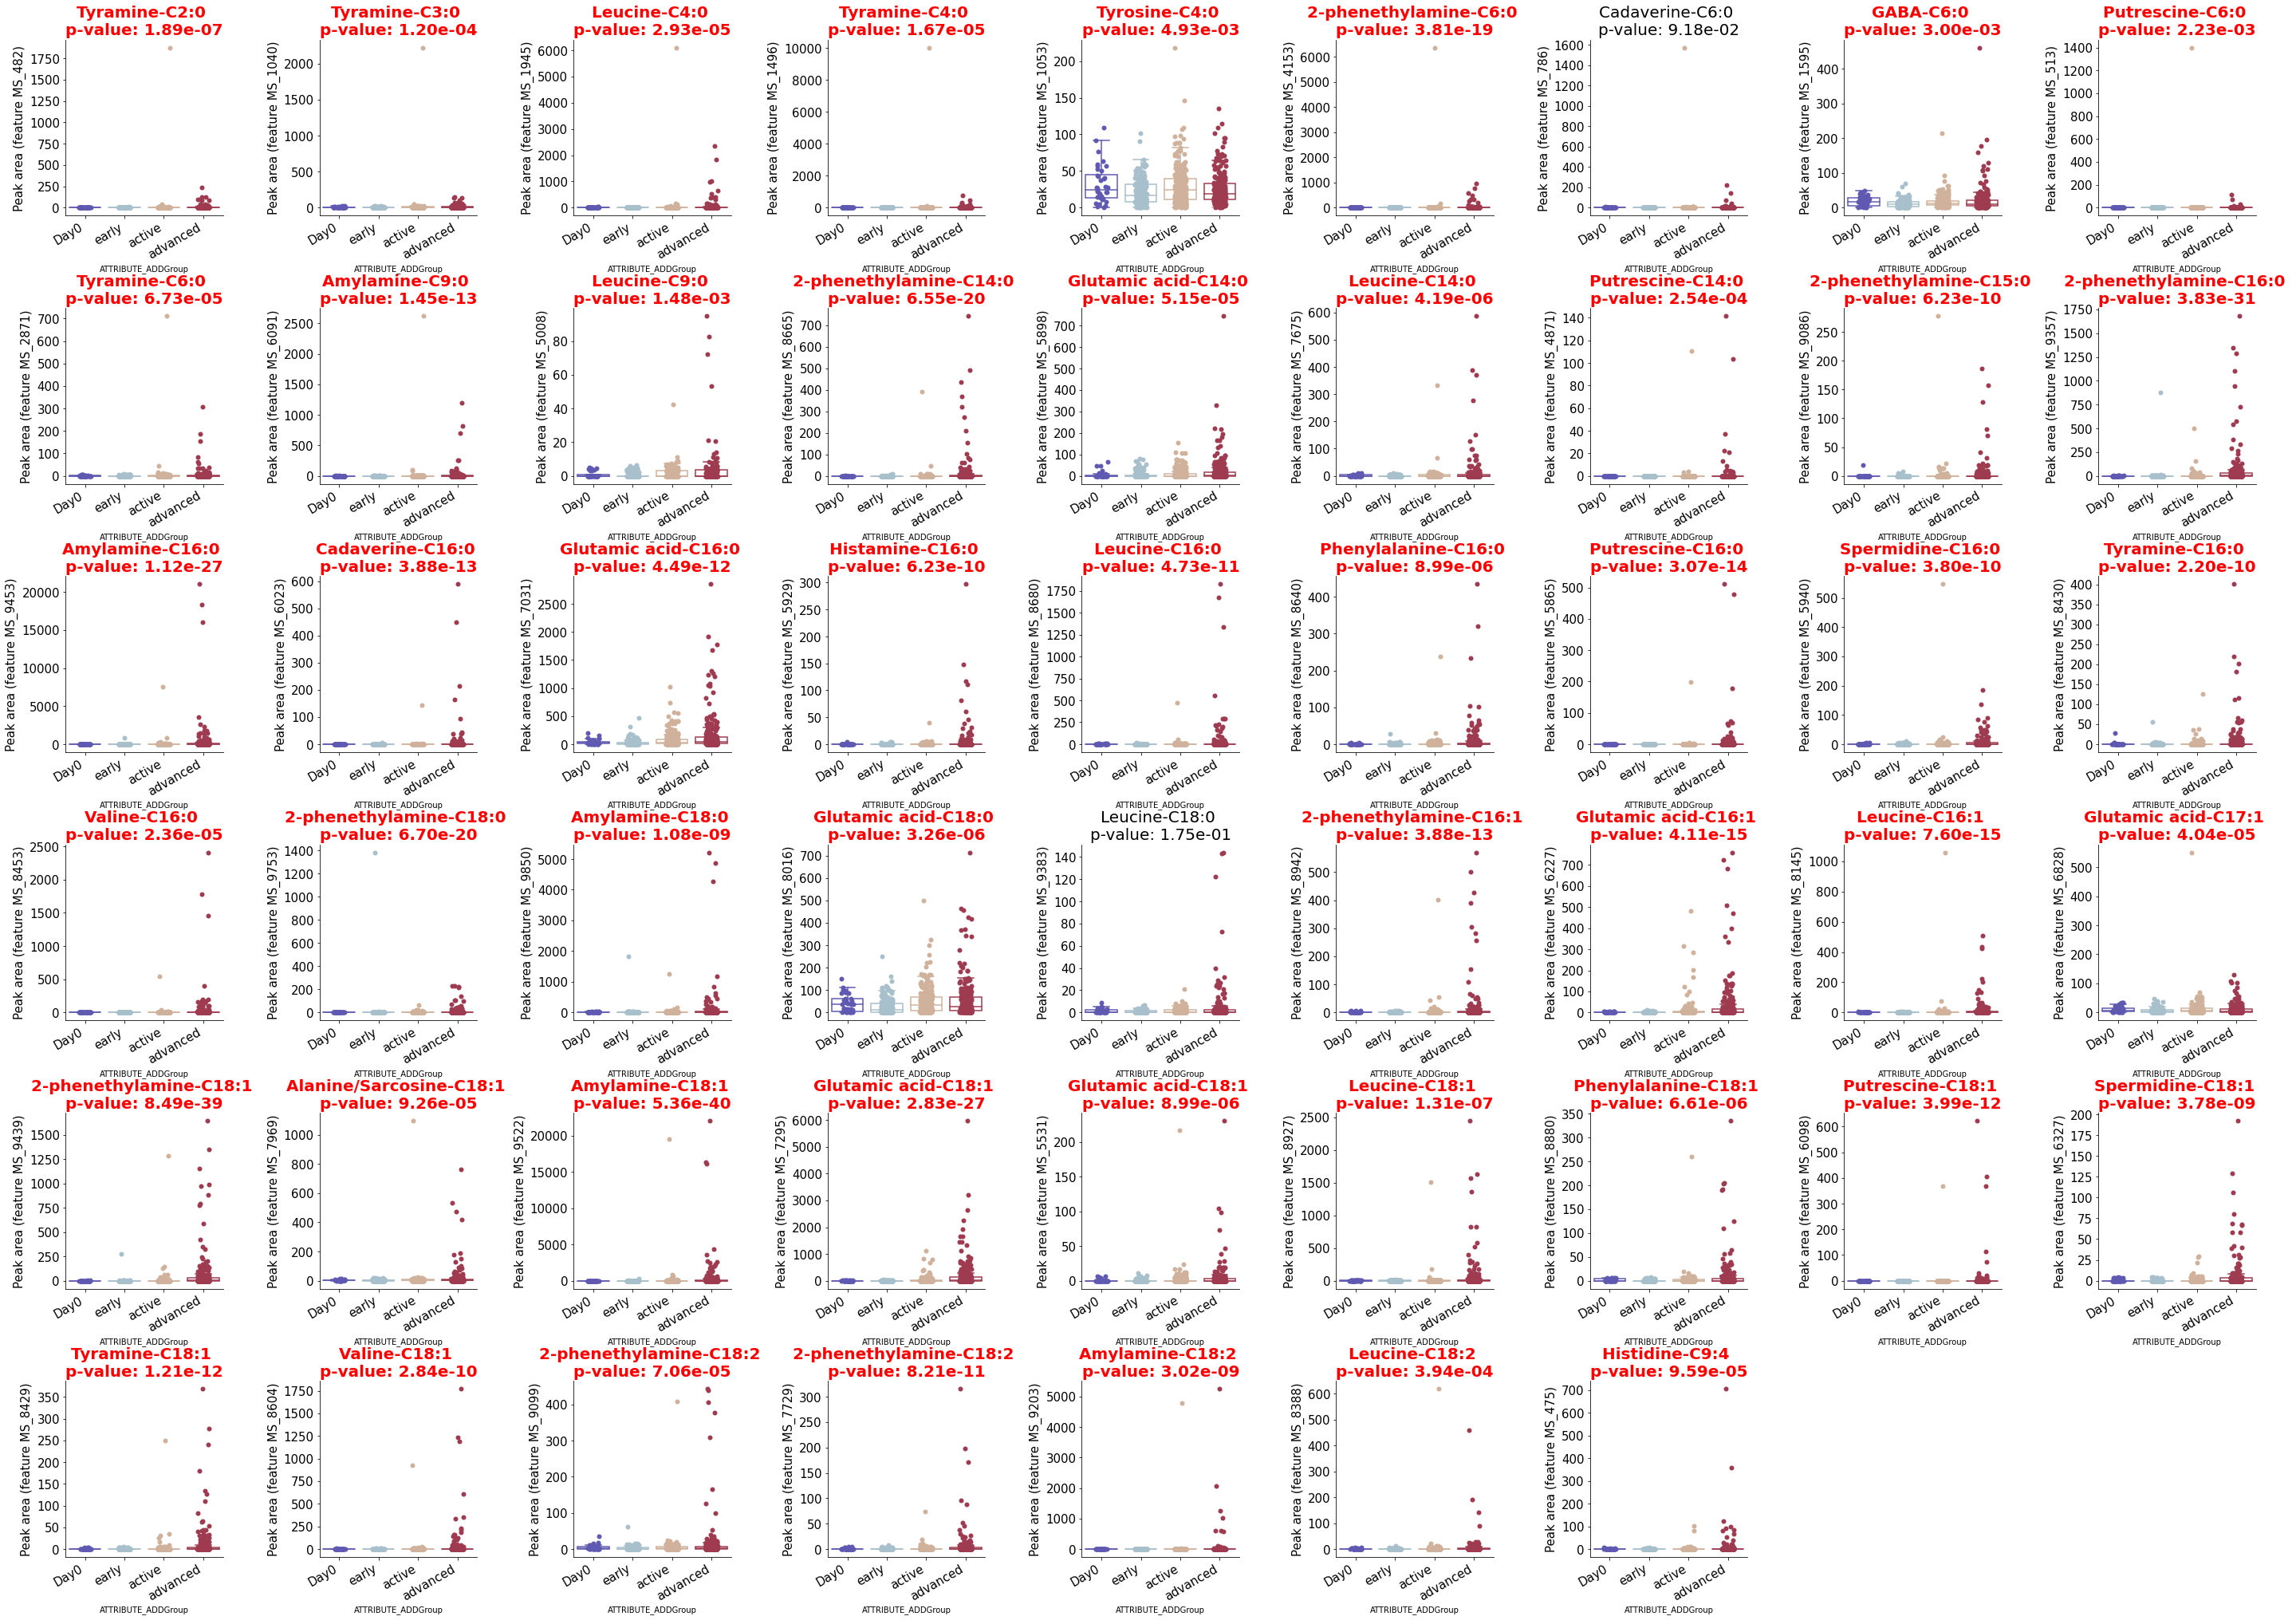

In [30]:
#reorganize the column order
metadata = pd.read_csv('/.../deltas_annotation_reordered.txt', sep='\t')
metadata['order'] = metadata['order'].astype(str).str.zfill(3)
ms_features = pd.DataFrame(ftable_filtered_merged.columns[2:], columns=['MS_#Scan#'])
ms_features = pd.merge(ms_features, library_matches[['MS_#Scan#', 'Compound_Name_simplified']], 
                       on='MS_#Scan#', how='left')
ms_features['annotation'] = ms_features['Compound_Name_simplified'].str.split('-').str[-1]
ms_features['annotation'] = ms_features['annotation'].str.replace(' ','')
ms_features = pd.merge(ms_features, metadata[['annotation','order']], on='annotation', how='left')
ms_features['order'] = ms_features['order'].astype(str) + '_'+ ms_features['Compound_Name_simplified'].str.split('-').str[0]
ms_features_reordered = ms_features.sort_values(by='order', ascending=True)

ordered_feature_names = ms_features_reordered['MS_#Scan#'].tolist()

# Placeholder dictionary to hold p-values
p_values = {}

# Assuming 'column_interest' categorizes the data into four groups
group_labels = ftable_filtered_merged[column_interest].unique()
if len(group_labels) < 2:
    raise ValueError("column_interest must divide the data into at least two groups for the Kruskal-Wallis test.")

for feature_name in ordered_feature_names:
    # Data for all groups
    group_data = [ftable_filtered_merged[ftable_filtered_merged[column_interest] == label][feature_name] for label in group_labels]
    
    # Perform the Kruskal-Wallis test
    k_stat, p_value = kruskal(*group_data)
    p_values[feature_name] = p_value

# Exclude any NaN p-values before FDR correction
pvals = [p for p in p_values.values() if not np.isnan(p)]
features = [f for f, p in p_values.items() if not np.isnan(p)]

# Apply FDR correction
rej, pvals_corrected, _, _ = smm.multipletests(pvals, alpha=0.05, method='fdr_bh')

# Update the p_values dictionary with corrected p-values
corrected_p_values = dict(zip(features, pvals_corrected))
p_values.update(corrected_p_values)

#plot
plt.figure(figsize=(40, 60))  # Adjust the figure size as needed

unique_values = ftable_filtered_merged[column_interest].unique().tolist()
ftable_filtered_merged[column_interest] = pd.Categorical(
    ftable_filtered_merged[column_interest], categories=unique_values, ordered=True)

# Function to generate a color palette
def generate_palette(n):
    return sns.color_palette("twilight_shifted", n)

# Assigning palette
my_pal = generate_palette(len(unique_values))
color_dict = {str(val): color for val, color in zip(unique_values, my_pal)}
color_dict_white = {key: 'white' for key in color_dict.keys()}
plt.yticks(fontsize=15)

for i, feature_name in enumerate(ordered_feature_names, 1):
    title_name = library_matches.loc[library_matches['MS_#Scan#'] == feature_name, 'Compound_Name_simplified'].iloc[0]
    plt.subplot(12, 9, i)
  
    fig = sns.boxplot(x=column_interest, y=feature_name, data=ftable_filtered_merged, notch=False, 
                      palette=color_dict_white, showfliers=False)    
    
    # Set box properties including edge color to match your palette
    for j, patch in enumerate(fig.artists):
        col = color_dict[ftable_filtered_merged[column_interest].unique()[j]]
        patch.set_edgecolor(col)

        num_lines = len(fig.lines)
        start_line_index = 6 * j
        end_line_index = start_line_index + 6
        for k in range(start_line_index, min(end_line_index, num_lines)):
            line = fig.lines[k]
            line.set_color(col)
            line.set_mfc(col)
            line.set_mec(col)

    # Add colored dots for each category
    for diet in ftable_filtered_merged[column_interest].unique():
        sns.stripplot(
            x=column_interest, 
            y=feature_name, 
            data=ftable_filtered_merged[ftable_filtered_merged[column_interest] == diet], 
            color=color_dict[diet], 
            jitter=0.15, 
            size=6,
            ax=fig
        )
    # Determine title color based on p-value
    if p_values[feature_name] <= 0.05:
        title_color = 'red'
        title_weight = 'bold'
    else:
        title_color = 'black'
        title_weight = 'normal'
        
    fig.set_ylabel(f'Peak area (feature {feature_name})', fontsize=15)
    plt.yticks(fontsize=15)
    plt.xticks(rotation=30, ha='right', fontsize=15)
    
    formatted_p_value = f"{p_values[feature_name]:.2e}"
    plt.title(f'{title_name}\np-value: {formatted_p_value}', fontsize=20, color=title_color, fontweight=title_weight)
    
plt.tight_layout()
plt.subplots_adjust(top=0.91)
sns.despine()

plt.savefig("/.../Supplementary_Figure_3k.pdf")
plt.show()
